<img src="../images/aeropython_logo.png" alt="AeroPython" style="width: 300px;"/>

# Interpolación y ajuste

_La últimas tareas importantes que vamos a ver cómo hacer con SciPy van a ser **interpolar** y **ajustar** una serie de puntos. Son tareas diferentes que aprovecharemos en circunstancias distintas, pero ambas muy útiles. Esta clase está basada en el artículo http://pybonacci.org/2013/08/15/ajuste-e-interpolacion-unidimensionales-basicos-en-python-con-scipy/ _

## Dos problemas diferentes

Supongamos que tenemos una serie de puntos que representan los datos de un cierto experimento. Como ejemplo, vamos a cargar los datos de la polar de un avión que están en el archivo `polar.dat`.

In [ ]:
# Visualizamos el archivo polar.dat
# !type ../data/polar.dat

La primera línea son los datos de $C_L$ y la segunda los datos de $C_D$. Recordamos que había que usar la función `np.loadtxt`, y en este caso no hay que especificar ningún argumento extra más porque ya por defecto detecta que los comentarios empiezan por `#`.

In [ ]:
# cargamos los datos

Vamos a representar esos datos con cruces azules (pista: usar `mew=2`, "marker edge width 2", para que las cruces se vean mejor):

In [ ]:
# Representamos los datos

Vemos la forma clásica de la polar de un avión. Hallando *el índice* del máximo valor de $C_L$ podemos descartar los datos fuera de la región de entrada en pérdida, y para eso necesitamos la función `np.argmax`:

In [ ]:
# Identificamos la región de la pérdida

In [ ]:
# identificamos el CLMAX

In [ ]:
# Representamos los datos dentro y fuera del modelo

Hay dos cosas que nos pueden interesar:

* Como *solo tenemos puntos intermedios*, no tenemos posibilidad de evaluar, por ejemplo, $C_L$ para un $C_D$ que no esté en los datos. Si **interpolamos** la curva ya podemos hacerlo.
* Sabemos que, fuera de la región de entrada en pérdida, la polar tiene *forma parabólica*. Si **ajustamos** la curva podemos hallar el $C_{D0}$ y el $k$.

## Interpolación

Para interpolar utilizaremos el paquete `interpolate` de SciPy:

Vamos a generar unos puntos de ejemplo para explicar cómo funciona. Para eso, vamos a usar simplemente la función $\sin{x}$ en un dominio con pocos puntos:

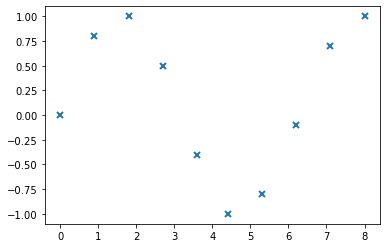

In [9]:
# aeropython: preserve
x_i = [0.0, 0.9, 1.8, 2.7, 3.6, 4.4, 5.3, 6.2, 7.1, 8.0]
y_i = [0.0, 0.8, 1.0, 0.5, -0.4, -1.0, -0.8, -0.1, 0.7, 1.0]
plt.plot(x_i, y_i, 'x', mew=2)

Para crear una **función interpolante** utilizaremos el objeto `InterpolatedUnivariateSpline` del paquete `interpolate`. A este objeto solo hay que pasarle los puntos de interpolación y el grado, y generará un *spline*.

¿Cómo obtengo los puntos desde aquí? El resultado que hemos obtenido es una *función* y admite como argumento la $x$.

Vamos a representar esta función junto con los puntos de interpolación. Fíjate en que, ahora que tenemos una función interpolante, podemos representarla en un dominio:

Retrocede ahora y comprueba lo que pasa si cambias el grado del *spline*.

**Ejercicio**: Crear una función interpolante $C_D = f(C_L)$ usando splines de grado 2 y representarla. Utiliza solo los datos que resultan de haber eliminado la región de entrada en pérdida. y ten en cuenta que la $x$ y la $y$ para este caso están cambiadas de sitio.

1. Crea un polinomio interpolante usando los valores que encajan en el modelo parabólico.
2. Crea un dominio de $C_L$ entre `C_L.min()` y `C_L.max()`.
3. Halla los valores interpolados de $C_D$ en ese dominio.
4. Representa la función y los puntos.

### Fenómeno de Runge 

In [14]:
# aeropython: preserve
def runge(x):
    return 1 / (1 + x ** 2)

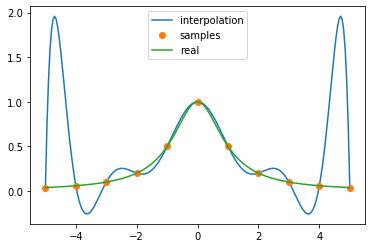

In [15]:
# aeropython: preserve
# Número de nodos
N = 11  # Nodos de interpolación

# Seleccionamos los nodos
xp = np.linspace(-5, 5, N)   # -5, -4, -3, ..., 3, 4, 5
fp = runge(xp)

# Seleccionamos la x para interpolar
x = np.linspace(-5, 5, 200)

# Calculamos el pol interp de Lagrange
lag_pol = interpolate.lagrange(xp, fp)

y = lag_pol(x)

# pintamos
plt.plot(x, y, label='interpolation')
plt.plot(xp, fp, 'o', label='samples')
plt.plot(x, runge(x), label='real')
plt.legend(loc='upper center')

In [16]:
# aeropython: preserve
# importamos el polinomio de chebychev
from numpy.polynomial import chebyshev

In [17]:
# aeropython: preserve
N = 11  # Nodos de interpolación

coeffs_cheb = [0] * N + [1]  # Solo queremos el elemento 11 de la serie
coeffs_cheb

T11 = chebyshev.Chebyshev(coeffs_cheb, [-5, 5])
xp_ch = T11.roots()

xp_ch

array([-4.94910721e+00, -4.54815998e+00, -3.77874787e+00, -2.70320409e+00,
       -1.40866278e+00, -1.34623782e-15,  1.40866278e+00,  2.70320409e+00,
        3.77874787e+00,  4.54815998e+00,  4.94910721e+00])

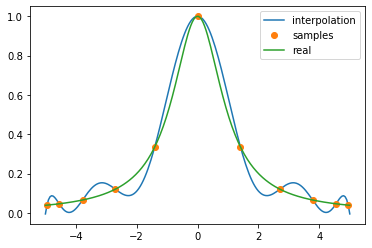

In [18]:
# aeropython: preserve
fp = runge(xp_ch)

x = np.linspace(-5, 5, 200)

lag_pol = interpolate.lagrange(xp_ch, fp)

y = lag_pol(x)

plt.plot(x, y, label='interpolation')
plt.plot(xp_ch, fp, 'o', label='samples')
plt.plot(x, runge(x), label='real')
plt.legend()

## Ajuste

El ajuste funciona de manera totalmente distinta: obtendremos una curva que no tiene por qué pasar por ninguno de los puntos originales, pero que a cambio tendrá una expresión analítica simple.

Vamos otra vez a generar unos datos para ver cómo funcionaría, del tipo:

$$y(x) = x^2 - x + 1 + \text{Ruido}$$

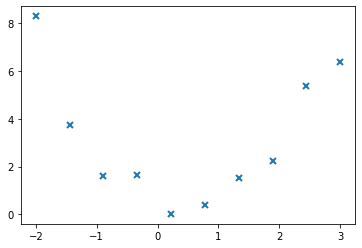

In [20]:
# aeropython: preserve
x_i = np.linspace(-2, 3, num=10)
y_i = x_i ** 2 - x_i + 1 + 0.5 * np.random.randn(10)
plt.plot(x_i, y_i, 'x', mew=2)

Vamos a utilizar la función `polynomial.polyfit`, que recibe los puntos de interpolación y el grado del polinomio. El resultado serán los coeficientes del mismo, **en orden de potencias crecientes**.

¡Muy similares a lo que esperábamos!

##### Ejercicio

Si modelizamos la polar como:

$$C_D = C_{D0} + k C_L^2$$

hallar los coeficientes $C_{D0}$ y $k$.

---
<br/>
#### <h4 align="right">¡Síguenos en Twitter!
<br/>
###### <a href="https://twitter.com/AeroPython" class="twitter-follow-button" data-show-count="false">Follow @AeroPython</a> <script>!function(d,s,id){var js,fjs=d.getElementsByTagName(s)[0],p=/^http:/.test(d.location)?'http':'https';if(!d.getElementById(id)){js=d.createElement(s);js.id=id;js.src=p+'://platform.twitter.com/widgets.js';fjs.parentNode.insertBefore(js,fjs);}}(document, 'script', 'twitter-wjs');</script> 
<br/>
###### Este notebook ha sido realizado por: Juan Luis Cano, y Álex Sáez 
<br/>
##### <a rel="license" href="http://creativecommons.org/licenses/by/4.0/deed.es"><img alt="Licencia Creative Commons" style="border-width:0" src="http://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">Curso AeroPython</span> por <span xmlns:cc="http://creativecommons.org/ns#" property="cc:attributionName">Juan Luis Cano Rodriguez y Alejandro Sáez Mollejo</span> se distribuye bajo una <a rel="license" href="http://creativecommons.org/licenses/by/4.0/deed.es">Licencia Creative Commons Atribución 4.0 Internacional</a>.

##### <script src="//platform.linkedin.com/in.js" type="text/javascript"></script> <script type="IN/MemberProfile" data-id="http://es.linkedin.com/in/juanluiscanor" data-format="inline" data-related="false"></script> <script src="//platform.linkedin.com/in.js" type="text/javascript"></script> <script type="IN/MemberProfile" data-id="http://es.linkedin.com/in/alejandrosaezm" data-format="inline" data-related="false"></script>

---
_Las siguientes celdas contienen configuración del Notebook_

_Para visualizar y utlizar los enlaces a Twitter el notebook debe ejecutarse como [seguro](http://ipython.org/ipython-doc/dev/notebook/security.html)_

    File > Trusted Notebook

In [30]:
# Esta celda da el estilo al notebook
from IPython.core.display import HTML
css_file = '../styles/aeropython.css'
HTML(open(css_file, "r").read())